In [112]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [245]:
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import DataLoader
import torch.optim as optim

from utils.dataset import FreiHAND
from utils.utils import show_sample
from utils.model import ShallowUNet

In [117]:
data_dir = "data/FreiHAND_pub_v2"
dataset = FreiHAND(data_dir)

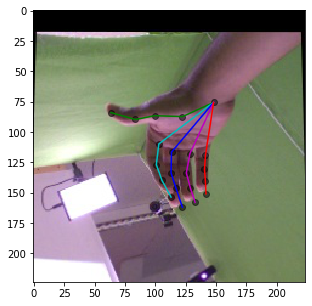

In [119]:
sample = dataset.__getitem__(1000)
image = sample["image"]
keypoints = sample["keypoints"]

show_sample(image, keypoints)

## Specifying Train Parameters

In [302]:
config = {
    "data_dir": "data/FreiHAND_pub_v2",
    "epochs": 2,
    "batch_size": 2,
    "batches_per_epoch": 2,
    "batches_per_epoch_val": 2,
}

In [285]:
dataset = FreiHAND(data_dir=config["data_dir"])
dataloader = DataLoader(dataset, config["batch_size"], shuffle=True, drop_last=True)

In [286]:
model = ShallowUNet(3, 21)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training

In [305]:
class Trainer:
    def __init__(self, model, criterion, optimizer, config):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]

    def train(self, train_dataloader, val_dataloader):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 5),
                    np.round(self.loss["val"][-1], 5),
                )
            )
        return self.model

    def _epoch_train(self, dataloader):
        self.model.train()
        running_loss = []

        for i, data in enumerate(dataloader, 0):
            inputs = data["image"]
            labels = data["heatmaps"]

            self.optimizer.zero_grad()
            running_loss = []

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())

            if i == self.batches_per_epoch:
                epoch_loss = np.mean(running_loss)
                self.loss["train"].append(epoch_loss)
                break

    def _epoch_eval(self, dataloader):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                inputs = data["image"]
                labels = data["heatmaps"]

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())

                if i == self.batches_per_epoch_val:
                    epoch_loss = np.mean(running_loss)
                    self.loss["val"].append(epoch_loss)
                    break

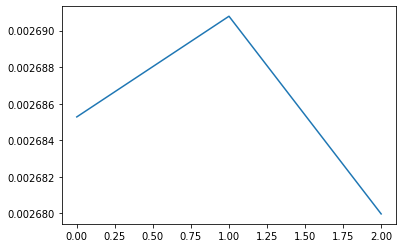

In [298]:
plt.plot(epoch_loss)